<a href="https://colab.research.google.com/github/grndnl/w266_final_project/blob/main/Understanding_if_elements_are_part_of_an_assembly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting whether two sets of assembly names are from the same assembly

In [ ]:
##Import

In [ ]:
import os, re
from pathlib import Path
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras import layers
import random
!pip install transformers
from transformers import AutoTokenizer, TFAutoModel
from sklearn.model_selection import train_test_split
from pprint import pprint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 4.2 MB/s 
     |████████████████████████████████| 7.6 MB 71.9 MB/s 
     |████████████████████████████████| 182 kB 78.3 MB/s 


In [ ]:
#tf.config.get_visible_devices(
#    device_type=None
#)

In [ ]:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#if gpus:
  # Restrict TensorFlow to only use the first GPU
#  try:
#    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
#  except RuntimeError as e:
    # Visible devices must be set at program startup
#    print(e)

In [ ]:
#tf.config.get_visible_devices(
#    device_type=None
#)

# Preprocess data

### Pre-process data for task

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/My Drive/W266/data_02.feather"
data = pd.read_feather(data_path)

In [ ]:
data = data.dropna(subset=["assembly_name", "part_names"])
#data = data.drop(columns=["assembly_id", 'assembly_description'])
data = data.drop(columns=["assembly_id"])
data.head()

,assembly_name,assembly_description,part_names
0,Lava Lamp 2,None,"[Blob3, Blob2, Blob1, Glass, Cap]"
1,Sample - Headphones,None,"[Pivot hinge, Headphone hinge, Telescope hinge..."
4,Coffee Mug,None,"[Mug, Lid]"
5,Dave's Handsome Mug,None,"[Lid, Seal, Vessel]"
9,Mechanical Pencil,None,"[Eraser, Pencil Lead, Rubber Grip, Gripper Rod..."


In [ ]:
# Deduplicate
print(f"Tot: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")
data = data[~data['part_names'].apply(tuple).duplicated()]
print(f"\nAfter dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name'].unique())}")

Tot: 88886
Unique: 67834

After dedup: 61725
Unique: 54034


### Clean assembly names

In [ ]:
def process_assembly_names(string):
    string = string.replace('.x_t', '')
    string = string.replace('.stp', '')
    string = string.replace('.step', '')
    string = string.replace('.zip', '')
    string = string.replace('.dwg', '')
    string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
    string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
    string = string.lower()
    string = string.replace('_', ' ')
    string = string.replace('-', ' ')
    string = string.replace('[', ' ')
    string = string.replace(']', ' ')
    string = string.replace('(', ' ')
    string = string.replace(')', ' ')
    string = string.replace('?', ' ')
    string = string.replace('*', ' ')
    string = string.replace('copy of', ' ')
    string = string.replace('copy', ' ')
    string = string.replace('sample', '')
    string = string.replace('2', '')
    string = string.replace('tutorial', '')
    string = " ".join(string.split())

    return string


data['assembly_name_clean'] = data.apply(lambda row: process_assembly_names(row.assembly_name), axis=1)

In [ ]:
print(f"After dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name_clean'].unique())}")

After dedup: 61725
Unique: 49240


In [ ]:

print(f"After dedup: {len(data)}")
print(f"Unique: {len(data['assembly_name_clean'].unique())}")

After dedup: 61725
Unique: 49240


### Clean part names

In [ ]:
def process_part_names(part_list):
    part_names = []
    for string in part_list:
        if "MANIFOLD_SOLID_BREP" in string:
            return np.nan
        string = string.replace('.x_t', '')
        string = string.replace('.stp', '')
        string = string.replace('.step', '')
        string = string.replace('.dwg', '')
        string = string.replace('.zip', '')
        string = ' '.join(re.findall('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', string))  # splits camelCase into camel case
        string = ' '.join(re.split('(\s+|^)([A-Za-z]+)\d+(\s+|$)', string))  # removes number at the end
        string = string.lower()
        string = string.replace('_', ' ')
        string = string.replace('-', ' ')
        string = string.replace('[', ' ')
        string = string.replace(']', ' ')
        string = string.replace('(', ' ')
        string = string.replace(')', ' ')
        string = string.replace('?', ' ')
        string = string.replace('*', ' ')
        string = string.replace('copy of', ' ')
        string = string.replace('copy', ' ')
        string = " ".join(string.split())

        part_names.append(string)

    random.shuffle(part_names)
    return list(set(part_names))


data['part_names_clean'] = data.apply(lambda row: process_part_names(row.part_names), axis=1)
data.dropna(subset=['part_names_clean'], inplace=True)

In [ ]:
data.head()

,assembly_name,assembly_description,part_names,assembly_name_clean,part_names_clean
0,Lava Lamp 2,None,"[Blob3, Blob2, Blob1, Glass, Cap]",lava lamp,"[glass, cap, blob]"
1,Sample - Headphones,None,"[Pivot hinge, Headphone hinge, Telescope hinge...",headphones,"[pivot hinge, headphone hinge, upper band, hea..."
4,Coffee Mug,None,"[Mug, Lid]",coffee mug,"[mug, lid]"
5,Dave's Handsome Mug,None,"[Lid, Seal, Vessel]",dave's handsome mug,"[vessel, lid, seal]"
9,Mechanical Pencil,None,"[Eraser, Pencil Lead, Rubber Grip, Gripper Rod...",mechanical pencil,"[button release, pencil lead, rubber grip, lea..."


In [ ]:
data.head()

,assembly_name,assembly_description,part_names,assembly_name_clean,part_names_clean
0,Lava Lamp 2,None,"[Blob3, Blob2, Blob1, Glass, Cap]",lava lamp,"[glass, cap, blob]"
1,Sample - Headphones,None,"[Pivot hinge, Headphone hinge, Telescope hinge...",headphones,"[pivot hinge, headphone hinge, upper band, hea..."
4,Coffee Mug,None,"[Mug, Lid]",coffee mug,"[mug, lid]"
5,Dave's Handsome Mug,None,"[Lid, Seal, Vessel]",dave's handsome mug,"[vessel, lid, seal]"
9,Mechanical Pencil,None,"[Eraser, Pencil Lead, Rubber Grip, Gripper Rod...",mechanical pencil,"[button release, pencil lead, rubber grip, lea..."


## Create sentences

In [73]:
sentence_pairs = []
for index, row in tqdm(data.iterrows(), total=len(data)):
    num_parts = len(row['part_names_clean'])
    if num_parts > 1 and row['assembly_description']!=None:
        sentence_1 = f"An assembly named '{row['assembly_name_clean']}' described as'{row['assembly_description']}' containing the following parts: "
        for part_name in row['part_names_clean'][:num_parts//2]:
                sentence_1 += f"{part_name}, "
        sentence_2 = ''
        for part_name in row['part_names_clean'][num_parts//2:]:
            sentence_2 += f"{part_name}, "
        sentence_2 = sentence_2[:-2] + "."

        sentence_pairs.append([sentence_1, sentence_2])
        #print(sentence_1)

    elif num_parts >1:
        sentence_1 = f"An assembly named '{row['assembly_name_clean']}' containing the following parts: "
        for part_name in row['part_names_clean'][:num_parts-1]:
                sentence_1 += f"{part_name}, "


        sentence_2 = ''
        for part_name in row['part_names_clean'][num_parts-1:]:
            sentence_2 += f"{part_name}, "
        sentence_2 = sentence_2[:-2] + "."

        sentence_pairs.append([sentence_1, sentence_2])


100%|██████████| 61601/61601 [00:03<00:00, 17910.77it/s]


In [74]:
random.shuffle(sentence_pairs)
print(len(sentence_pairs))
pprint(sentence_pairs[:50])

40240
[["An assembly named 'moteur' containing the following parts: magnet s, shell, "
  'rotor, primary gear, ',
  'magnet n.'],
 ["An assembly named 'perrinn lmp' containing the following parts: p 11 056 a "
  'panel arch tail right, p 02 011 a wheel tether pin 1, p 11 007 a flap, p 03 '
  '005 a clevis rear wb upper, p 11 183 a floor tyre seal rr, p 07 022 a '
  'closing shim damper valve, p 01 022 a barrel crash box front model, p 07 '
  '013 a bracket throttle damper, p 11 167 a bracket side panel obd right, p '
  '11 156 a fwep packer left model, p 01 145 a sub insert chassis engine '
  'generic mid right, p 01 117 a sub insert chassis wb lower fr, p 04 021 a '
  'sub hub steering wheel, p 01 103 a sub insert chassis jack, p 01 063 a sub '
  'latch, p 03 013 a bracket arb rocker, p 04 036 a roller steering rack, p 13 '
  '007 a pad, p 01 099 a sub insert chassis hinge low left, p 07 001 a pedal '
  'throttle, p 01 009 a windscreen model, p 11 177 a carbon duct caliper fl, p '
  '

# Train test split

In [75]:
positive_samples = sentence_pairs[:len(sentence_pairs)//2]
negative_samples = sentence_pairs[len(sentence_pairs)//2:]
#positive_samples = sentence_pairs[:len(sentence_pairs)]
#negative_samples = sentence_pairs[:len(sentence_pairs)]

In [76]:
negative_sentence_1 = [pair[0] for pair in negative_samples]
pprint(negative_sentence_1[:10])

["An assembly named 'wp conn ver 3' containing the following parts: sensor, ",
 "An assembly named 'schrank vw bus' containing the following parts: tiefe, "
 '3er ecke, breite, gesamtbreite, ',
 "An assembly named 'assem1topat .step' containing the following parts: f 6at "
 '2 v\\x2\\00ec\\x0\\choz\\x2\\00a1\\x0\\, f 5at 2 '
 'v\\x2\\00ec\\x0\\choz\\x2\\00a1\\x0\\, f 1at 2 '
 'v\\x2\\00ec\\x0\\choz\\x2\\00a1\\x0\\, f 2at 2 '
 'v\\x2\\00ec\\x0\\choz\\x2\\00a1\\x0\\, f 7at 2 '
 'v\\x2\\00ec\\x0\\choz\\x2\\00a1\\x0\\, f 3at 2 '
 'v\\x2\\00ec\\x0\\choz\\x2\\00a1\\x0\\, ',
 "An assembly named 'house' containing the following parts: water tank, washer "
 'cover, small bed, desk, stairs, toilet, bathroom wall 1, vent hood, guard 3, '
 'pantry, loft, closet, door, trailer, main bed, roof, removable camera, guard '
 '1, stove cover, bathroom wall 2, guard 2, ',
 "An assembly named 'pix racer r' containing the following parts: emifil 0603, "
 'user library ms5611 01ba03, ptc fuse 1206, user libr

In [77]:
# Scramble the negative samples while maintaining the sentence pair order
print(negative_samples[1])
print(positive_samples[1])

negative_sentence_1 = [pair[0] for pair in negative_samples]
negative_sentence_2 = [pair[1] for pair in negative_samples]
random.shuffle(negative_sentence_2)
negative_samples = [list(x) for x in zip(negative_sentence_1, negative_sentence_2)]
print(negative_samples[1])

["An assembly named 'schrank vw bus' containing the following parts: tiefe, 3er ecke, breite, gesamtbreite, ", 'hoehe.']
["An assembly named 'perrinn lmp' containing the following parts: p 11 056 a panel arch tail right, p 02 011 a wheel tether pin 1, p 11 007 a flap, p 03 005 a clevis rear wb upper, p 11 183 a floor tyre seal rr, p 07 022 a closing shim damper valve, p 01 022 a barrel crash box front model, p 07 013 a bracket throttle damper, p 11 167 a bracket side panel obd right, p 11 156 a fwep packer left model, p 01 145 a sub insert chassis engine generic mid right, p 01 117 a sub insert chassis wb lower fr, p 04 021 a sub hub steering wheel, p 01 103 a sub insert chassis jack, p 01 063 a sub latch, p 03 013 a bracket arb rocker, p 04 036 a roller steering rack, p 13 007 a pad, p 01 099 a sub insert chassis hinge low left, p 07 001 a pedal throttle, p 01 009 a windscreen model, p 11 177 a carbon duct caliper fl, p 04 035 a axle rack roller, p 04 039 a sub u joint model, p 02 026

In [78]:
# Create labels: 1 = positive, 0 = negative
positive_samples = [(sample, 1) for sample in positive_samples]
negative_samples = [(sample, 0) for sample in negative_samples]

sentence_pairs = positive_samples + negative_samples

In [79]:
negative_samples

[(["An assembly named 'wp conn ver 3' containing the following parts: sensor, ",
   'front wing pillar.'],
  0),
 (["An assembly named 'schrank vw bus' containing the following parts: tiefe, 3er ecke, breite, gesamtbreite, ",
   'magnet.'],
  0),
 (["An assembly named 'assem1topat .step' containing the following parts: f 6at 2 v\\x2\\00ec\\x0\\choz\\x2\\00a1\\x0\\, f 5at 2 v\\x2\\00ec\\x0\\choz\\x2\\00a1\\x0\\, f 1at 2 v\\x2\\00ec\\x0\\choz\\x2\\00a1\\x0\\, f 2at 2 v\\x2\\00ec\\x0\\choz\\x2\\00a1\\x0\\, f 7at 2 v\\x2\\00ec\\x0\\choz\\x2\\00a1\\x0\\, f 3at 2 v\\x2\\00ec\\x0\\choz\\x2\\00a1\\x0\\, ",
   'rx.'],
  0),
 (["An assembly named 'house' containing the following parts: water tank, washer cover, small bed, desk, stairs, toilet, bathroom wall 1, vent hood, guard 3, pantry, loft, closet, door, trailer, main bed, roof, removable camera, guard 1, stove cover, bathroom wall 2, guard 2, ",
   'case.'],
  0),
 (["An assembly named 'pix racer r' containing the following parts: emifil 060

In [80]:
train, test = train_test_split(sentence_pairs, test_size=0.2)
print(f"Length of train: {len(train)}")
print(f"Length of test: {len(test)}")

Length of train: 32192
Length of test: 8048


In [81]:
train[:5]

[(["An assembly named 'extruder 1.75 bowden blocks one' containing the following parts: extruder nut, revolution, bearing example, ",
   'idler.'],
  1),
 (["An assembly named 'barrière articulée 01016' containing the following parts: support 2 motor\\x2\\00e9\\x0\\ducteur, barre, ",
   'axe moteur.'],
  1),
 (["An assembly named 'atlas lathe table .0' containing the following parts: trim shelf, caul, side shelf, base trim side, backstop, carcase side rear, base trim face, carcase side, carcase rear center, center shelf, trim shelf center, trim pillar, ",
   'carcase rear center short.'],
  1),
 (["An assembly named '1fac' containing the following parts: carr lane 12fac default 12fac pin, carr lane 12fac default 12fac tip, carr lane 12fac default 12fac screw, carr lane 12fac default 12fac body, carr lane 12fac default 12fac spacer, ",
   'v slot 20x20x200.'],
  0),
 (["An assembly named 'pi zero' containing the following parts: 0204 capacitor 30, raspberry pizero bcm2835 with vc, 0204 

In [82]:
# Save out train data

train_data_path = "/content/drive/My Drive/W266/entailment/train_entailment.csv"
train_df = pd.DataFrame(train)

if not os.path.exists(Path(train_data_path).parent):
    os.mkdir(Path(train_data_path).parent)

train_df.to_csv(train_data_path, index=False)

In [83]:
def preprocess_data(data, tokenizer, max_length=128):
    labels = [item[1] for item in data]
    sentence_pairs = [item[0] for item in data]

    # With BERT tokenizer's batch_encode_plus, sentence pairs are
    # encoded together and separated by [SEP] token.
    encoded = tokenizer.batch_encode_plus(
        sentence_pairs,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_token_type_ids=True,
        return_tensors="tf"
    )

    # Extract encoded features and labels, add to corresponding lists
    input_ids = np.array(encoded["input_ids"], dtype="int32")
    attention_masks = np.array(encoded["attention_mask"], dtype="int32")
    token_type_ids = np.array(encoded["token_type_ids"], dtype="int32")
    
    return [input_ids, attention_masks, token_type_ids], np.array(labels)

# Construct the model

In [ ]:
def build_baseline_model(bert_model, max_length=128, hidden_dim=256):
    input_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='input_ids')
    attention_masks = layers.Input(shape=(max_length), dtype=tf.int32, name='attention_masks')
    token_type_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='token_type_ids')

    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    sequence_output=bert_output[1]
    #sequence_output = bert_output.last_hidden_state

    #attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=100)(sequence_output, sequence_output)
    #max_pool = layers.GlobalMaxPooling1D()(attn_output)
    #dropout_output = layers.Dropout(0.3)(max_pool)
    final_output = layers.Dense(1, activation="sigmoid")(sequence_output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [84]:
def build_New_model(bert_model, train_layers=-1, max_length=128):

    if train_layers == -1:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    else:
        # Restrict training to the train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)
          
        
        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                print('freezing: ', w)
                w._trainable = False

    input_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='input_ids')
    attention_masks = layers.Input(shape=(max_length), dtype=tf.int32, name='attention_masks')
    token_type_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='token_type_ids')

    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    sequence_output=bert_output[1]
    #sequence_output = bert_output.last_hidden_state

    #attn_output = layers.MultiHeadAttention(num_heads=4, key_dim=100)(sequence_output, sequence_output)
    #max_pool = layers.GlobalMaxPooling1D()(attn_output)
    #dropout_output = layers.Dropout(0.3)(max_pool)
    final_output = layers.Dense(1, activation="sigmoid")(sequence_output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
def build_New_model2(bert_model, max_length=128, hidden_dim=256):
    input_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='input_ids')
    attention_masks = layers.Input(shape=(max_length), dtype=tf.int32, name='attention_masks')
    token_type_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='token_type_ids')

    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    sequence_output = bert_output.last_hidden_state

    hidden = tf.keras.layers.Dense(hidden_dim, activation='relu', name='hidden_layer')(sequence_output)

    hidden = tf.keras.layers.Dense(hidden_dim/2, activation='relu', name='hidden_layer2')(hidden)

    attn_output = layers.MultiHeadAttention(num_heads=8, key_dim=100)(hidden, hidden)
    max_pool = layers.GlobalMaxPooling1D()(attn_output)
    dropout_output = layers.Dropout(0.3)(max_pool)
    final_output = layers.Dense(1, activation="sigmoid")(dropout_output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [102]:
def build_New_model3(bert_model, max_length=128, hidden_dim=256):
    input_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='input_ids')
    attention_masks = layers.Input(shape=(max_length), dtype=tf.int32, name='attention_masks')
    token_type_ids = layers.Input(shape=(max_length), dtype=tf.int32, name='token_type_ids')

    bert_output = bert_model(input_ids, attention_mask=attention_masks, token_type_ids=token_type_ids)
    sequence_output = bert_output.last_hidden_state
    print(sequence_output)
    attn_output = layers.MultiHeadAttention(num_heads=8, key_dim=16)(sequence_output, sequence_output)

    #hidden = tf.keras.layers.Dense(hidden_dim, activation='relu', name='hidden_layer')(attn_output)

    #hidden = tf.keras.layers.Dense(hidden_dim, activation='relu', name='hidden_layer2')(hidden)

    max_pool = layers.GlobalMaxPooling1D()(attn_output)
    dropout_output = layers.Dropout(0.3)(max_pool)
    final_output = layers.Dense(1, activation="sigmoid")(dropout_output)

    model = tf.keras.models.Model(inputs=[input_ids, attention_masks, token_type_ids],
                                  outputs=[final_output])
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [85]:
bert_model_name='bert-base-uncased'
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)
bert_model = TFAutoModel.from_pretrained(bert_model_name)
bert_model.trainable = True

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [103]:
model3= build_New_model3(bert_model, max_length=128, hidden_dim=128)

KerasTensor(type_spec=TensorSpec(shape=(None, 128, 768), dtype=tf.float32, name=None), name='tf_bert_model_5/bert/encoder/layer_._11/output/LayerNorm/batchnorm/add_1:0', description="created by layer 'tf_bert_model_5'")


In [94]:
#model = build_baseline_model(bert_model, max_length=128, hidden_dim=256)
model1=build_New_model(bert_model, train_layers=1, max_length=128)
#model2 = build_New_model2(bert_model, max_length=128, hidden_dim=128)
#model3= build_New_model3(bert_model, max_length=128, hidden_dim=128)
#model.summary()
#model2.summary()
#model3.summary()

Se han truncado las últimas 5000 líneas del flujo de salida.
       -1.14851385e-01,  3.48176546e-02,  2.91756038e-02, -1.16065040e-01,
       -4.21991646e-02,  7.56498575e-02, -2.72959862e-02, -7.20958412e-03,
        6.31969571e-02, -1.10702097e-01,  5.46961650e-02,  4.43459004e-02,
        8.98713693e-02, -6.78615123e-02, -6.25809329e-03,  8.58957544e-02,
        9.13264602e-02,  4.34004422e-03,  1.19181551e-01,  9.50944275e-02,
       -2.46985890e-02,  2.39464447e-01, -2.20720097e-02, -3.01526915e-02,
        3.17783840e-02, -1.57404132e-02, -1.13537963e-02,  8.05089716e-03,
       -8.99994466e-03,  3.48527404e-03,  1.52412045e-03,  2.96975649e-03,
        8.53402074e-03, -5.79730980e-03, -1.36348896e-03,  5.48646273e-03,
        9.71920416e-03, -7.67358870e-04, -1.02122044e-02, -7.62122031e-03,
        1.30707887e-03,  2.68272194e-03,  6.72193244e-03, -2.28234138e-02,
       -3.44908163e-02, -2.07651705e-02, -2.39741756e-03, -5.91028854e-03,
        2.06955075e-02, -1.42667508e-02

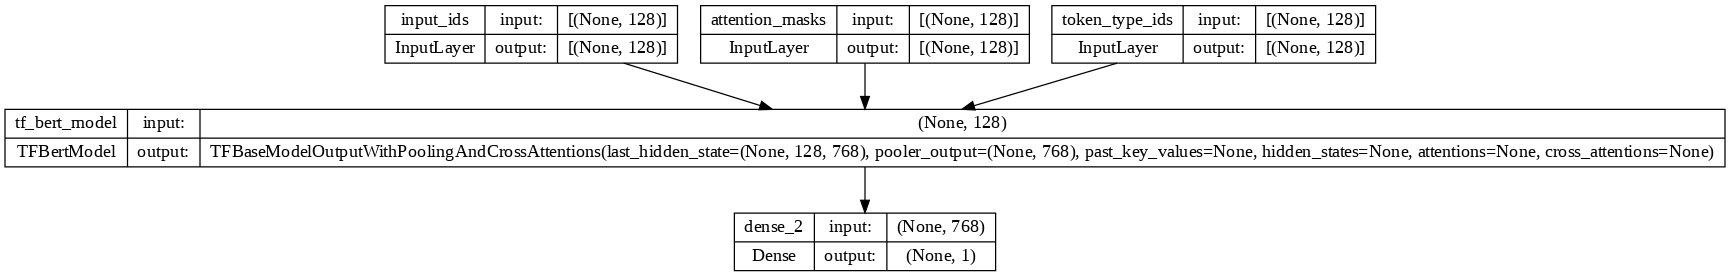

In [ ]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [87]:
class SNLIDataGeneratorFromFile(tf.keras.utils.Sequence):
    def __init__(self,
                 tokenizer,
                 n_examples,
                 data_filename,
                 max_length=128,
                 batch_size=32,
                 shuffle=True):
        
        self.tokenizer = tokenizer
        self.n_examples = n_examples
        self.data_filename = data_filename
        self.max_length = max_length
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        # Initialize row order, call on_epoch_end to shuffle row indices
        self.row_order = np.arange(1, self.n_examples+1)
        self.on_epoch_end()
    
    def __len__(self):
        return self.n_examples // self.batch_size

    def __getitem__(self, idx):
        batch_start = idx * self.batch_size
        batch_end = (idx + 1) * self.batch_size

        # Indices to skip are the ones in the shuffled row_order before and
        # after the chunk we'll use for this batch
        batch_idx_skip = self.row_order[:batch_start] + self.row_order[batch_end:]
        train_data_df = pd.read_csv(self.data_filename, skiprows=batch_idx_skip)

        train_data = []
        for index, row in train_data_df.iterrows():
            train_data.append((row[0], row[1]))

        batch_data = preprocess_data(
            train_data,
            self.tokenizer,
            self.max_length
        )

        return batch_data
    
    def on_epoch_end(self):
        if self.shuffle:
            self.row_order = list(np.random.permutation(self.row_order))

In [88]:
train_data_generator = SNLIDataGeneratorFromFile(
    tokenizer=bert_tokenizer,
    n_examples=len(train),
    data_filename=train_data_path,
    batch_size=16
)

In [89]:
test_data = preprocess_data(
    test, tokenizer=bert_tokenizer, max_length=128
)

In [90]:
checkpoint_dir = '/content/drive/My Drive/W266/entailment/'
checkpoint_filepath = checkpoint_dir + 'weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

## Train model

In [91]:
tf.config.experimental_run_functions_eagerly(True)

In [99]:
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)


In [95]:
history=model.fit(train_data_generator, validation_data=test_data, epochs=10,
          callbacks=[model_checkpoint_callback])

Epoch 1/10
   1/2012 [..............................] - ETA: 21:33 - loss: 0.5581 - accuracy: 0.8750

KeyboardInterrupt: ignored

In [100]:
history=model1.fit(train_data_generator, validation_data=test_data, epochs=10,
          callbacks=[model_checkpoint_callback])

Epoch 1/10
2012/2012 [==============================] - 598s 297ms/step - loss: 0.6781 - accuracy: 0.5737 - val_loss: 0.7449 - val_accuracy: 0.5127
Epoch 2/10
2012/2012 [==============================] - 594s 295ms/step - loss: 0.6255 - accuracy: 0.6394 - val_loss: 0.7440 - val_accuracy: 0.5225
Epoch 3/10
2012/2012 [==============================] - 587s 291ms/step - loss: 0.5916 - accuracy: 0.6664 - val_loss: 0.7372 - val_accuracy: 0.5263
Epoch 4/10
2012/2012 [==============================] - 593s 294ms/step - loss: 0.5754 - accuracy: 0.6717 - val_loss: 0.6955 - val_accuracy: 0.5355
Epoch 5/10
2012/2012 [==============================] - 585s 290ms/step - loss: 0.5678 - accuracy: 0.6760 - val_loss: 0.6966 - val_accuracy: 0.4917
Epoch 6/10
2012/2012 [==============================] - 584s 290ms/step - loss: 0.5686 - accuracy: 0.6744 - val_loss: 0.6971 - val_accuracy: 0.5220
Epoch 7/10
2012/2012 [==============================] - 585s 291ms/step - loss: 0.5561 - accuracy: 0.6853 - val_

In [106]:
history1=model3.fit(train_data_generator, validation_data=test_data, epochs=10,
          callbacks=[model_checkpoint_callback])

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


2012/2012 [==============================] - 610s 303ms/step - loss: 0.5287 - accuracy: 0.7071 - val_loss: 0.6951 - val_accuracy: 0.5195
Epoch 2/10
2012/2012 [==============================] - 609s 302ms/step - loss: 0.5199 - accuracy: 0.7129 - val_loss: 0.6827 - val_accuracy: 0.5186
Epoch 3/10
2012/2012 [==============================] - 604s 300ms/step - loss: 0.5151 - accuracy: 0.7150 - val_loss: 0.6819 - val_accuracy: 0.5429
Epoch 4/10
2012/2012 [==============================] - 603s 300ms/step - loss: 0.5112 - accuracy: 0.7157 - val_loss: 0.6847 - val_accuracy: 0.5544
Epoch 5/10
2012/2012 [==============================] - 610s 303ms/step - loss: 0.5046 - accuracy: 0.7212 - val_loss: 0.6791 - val_accuracy: 0.5922
Epoch 6/10
2012/2012 [==============================] - 602s 299ms/step - loss: 0.5026 - accuracy: 0.7242 - val_loss: 0.6737 - val_accuracy: 0.5915
Epoch 7/10
2012/2012 [==============================] - 602s 299ms/step - loss: 0.4987 - accuracy: 0.7265 - val_loss: 0.659

In [104]:
def make_plot(axs, history1, 
              history2, 
              y_lim_loss_lower=0.4, 
              y_lim_loss_upper=0.6,
              y_lim_accuracy_lower=0.7, 
              y_lim_accuracy_upper=0.8,
              model_1_name='model 1',
              model_2_name='model 2',
              
             ):
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    ax1 = axs[0, 0]
    ax1.plot(history1.history['loss'])
    ax1.plot(history1.history['val_loss'])
    ax1.set_title('loss - ' + model_1_name)
    ax1.set_ylabel('loss', bbox=box)
    ax1.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax3 = axs[1, 0]
    ax3.set_title('accuracy - ' + model_1_name)
    ax3.plot(history1.history['accuracy'])
    ax3.plot(history1.history['val_accuracy'])
    ax3.set_ylabel('accuracy', bbox=box)
    ax3.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)


    ax2 = axs[0, 1]
    ax2.set_title('loss - ' + model_2_name)
    ax2.plot(history2.history['loss'])
    ax2.plot(history2.history['val_loss'])
    ax2.set_ylim(y_lim_loss_lower, y_lim_loss_upper)

    ax4 = axs[1, 1]
    ax4.set_title('accuracy - ' + model_2_name)

    # small adjustment to account for the 2 accuracy measures in the Weighted Averging Model with Attention
    if 'classification_accuracy' in history2.history.keys():
      ax4.plot(history2.history['classification_accuracy'])
    else:
      ax4.plot(history2.history['accuracy'])
    
    if 'val_classification_accuracy' in history2.history.keys():
      ax4.plot(history2.history['val_classification_accuracy'])
    else:
      ax4.plot(history2.history['val_accuracy'])
    ax4.set_ylim(y_lim_accuracy_lower, y_lim_accuracy_upper)

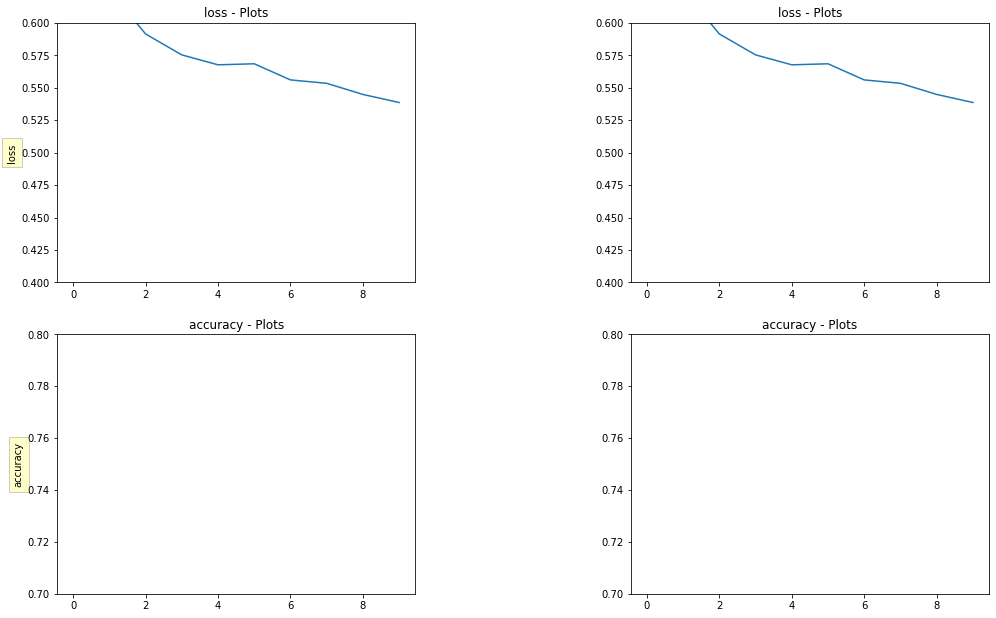

In [105]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2)
fig.subplots_adjust(left=0.2, wspace=0.6)
make_plot(axs, history, history,model_1_name='Plots', model_2_name='Plots')

fig.align_ylabels(axs[:, 1])
fig.set_size_inches(18.5, 10.5)
plt.show()